In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords

In [4]:
torch.manual_seed(12345)

Distributional hypothesis: Words appearing in similar contexts are related to each other semantically. This idea help to find semantic similarity. However, in real cases, thousands of different semantic attributes may be relevant to determining similarity, and then deep learning is introduced to learns representations of the features. The main idea is to let the word embeddings be parameters in the model, which will then be updated during training.
Word embeddings are a representation of the *semantics* of a word, efficiently encoding semantic information that might be relevant to the task at hand. 


In [5]:
word_to_ix = {"hello": 0, "world": 1}

In [6]:
idx = list(word_to_ix.values())
embeds_dim = 5

lookup = torch.randn((len(idx), embeds_dim), dtype=torch.float) # The lookup table for embedding
embeds = lookup[idx] # Embedding 

print(embeds)

tensor([[ 1.4271, -1.8701, -1.1962, -2.0440, -0.4560],
        [-1.4295, -0.7175,  1.3922,  0.0811, -1.1936]])


In [33]:
embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings
lookup_tensor = torch.tensor([word_to_ix["hello"]], dtype=torch.long)
hello_embed = embeds(lookup_tensor)
print(hello_embed)

tensor([[-0.7146,  1.5206,  1.5217,  3.1939, -0.0270]],
       grad_fn=<EmbeddingBackward0>)


In [8]:
# We will use Shakespeare Sonnet 2
words = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold."""

In [35]:
# Tokenize the text and remove punvtuation
punctuations = set(string.punctuation)
words = [w for w in nltk.word_tokenize(words.lower()) if w not in punctuations]
print(words)

['when', 'forty', 'winters', 'shall', 'besiege', 'thy', 'brow', 'and', 'dig', 'deep', 'trenches', 'in', 'thy', 'beauty', "'s", 'field', 'thy', 'youth', "'s", 'proud', 'livery', 'so', 'gazed', 'on', 'now', 'will', 'be', 'a', 'totter', "'d", 'weed', 'of', 'small', 'worth', 'held', 'then', 'being', 'asked', 'where', 'all', 'thy', 'beauty', 'lies', 'where', 'all', 'the', 'treasure', 'of', 'thy', 'lusty', 'days', 'to', 'say', 'within', 'thine', 'own', 'deep', 'sunken', 'eyes', 'were', 'an', 'all-eating', 'shame', 'and', 'thriftless', 'praise', 'how', 'much', 'more', 'praise', 'deserv', "'d", 'thy', 'beauty', "'s", 'use', 'if', 'thou', 'couldst', 'answer', "'this", 'fair', 'child', 'of', 'mine', 'shall', 'sum', 'my', 'count', 'and', 'make', 'my', 'old', 'excuse', 'proving', 'his', 'beauty', 'by', 'succession', 'thine', 'this', 'were', 'to', 'be', 'new', 'made', 'when', 'thou', 'art', 'old', 'and', 'see', 'thy', 'blood', 'warm', 'when', 'thou', "feel'st", 'it', 'cold']


In [36]:
n = 3 # Use 3grams

In [37]:
# Build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams1 = []
for i in range((n-1), len(words)):
  target_word = words[i]
  pre_words = []
  for j in range(n-1):
    pre_words.append(words[i-j-1])
  ngrams1.append((list(reversed(pre_words)), target_word))

In [38]:
ngrams1[:3]

[(['when', 'forty'], 'winters'),
 (['forty', 'winters'], 'shall'),
 (['winters', 'shall'], 'besiege')]

In [39]:
ngrams2 = []
for i in range((n-1), len(words)):
  target = words[i]
  pre_words = words[i-(n-1):i] # Left closed, right open, thus till the i
  ngrams2.append((pre_words, target))

In [40]:
ngrams2[:3]

[(['when', 'forty'], 'winters'),
 (['forty', 'winters'], 'shall'),
 (['winters', 'shall'], 'besiege')]

In [41]:
ngrams = [(words[i-(n-1):i], words[i]) for i in range((n-1), len(words))]
print(ngrams[:3])
print(f'total number of sample: {len(ngrams)}')

[(['when', 'forty'], 'winters'), (['forty', 'winters'], 'shall'), (['winters', 'shall'], 'besiege')]
total number of sample: 118


In [42]:
vocab = set(words)
word_to_ix = {word: i for i, word in enumerate(vocab)}
print(word_to_ix)

{'thou': 0, 'field': 1, 'couldst': 2, 'the': 3, 'made': 4, "'s": 5, 'will': 6, 'proving': 7, 'an': 8, 'old': 9, 'brow': 10, 'when': 11, 'if': 12, 'shall': 13, 'his': 14, 'lusty': 15, 'a': 16, 'besiege': 17, 'blood': 18, 'weed': 19, 'mine': 20, 'then': 21, 'see': 22, 'succession': 23, 'treasure': 24, 'where': 25, 'youth': 26, 'eyes': 27, 'all': 28, 'be': 29, 'fair': 30, "feel'st": 31, 'praise': 32, 'now': 33, 'make': 34, 'say': 35, 'forty': 36, 'own': 37, 'trenches': 38, 'proud': 39, 'small': 40, 'held': 41, 'how': 42, 'all-eating': 43, 'gazed': 44, 'within': 45, 'and': 46, 'asked': 47, 'of': 48, 'my': 49, 'by': 50, 'thine': 51, 'on': 52, 'use': 53, 'worth': 54, 'winters': 55, 'to': 56, 'shame': 57, 'thy': 58, 'more': 59, 'being': 60, 'answer': 61, 'totter': 62, 'so': 63, 'new': 64, 'dig': 65, 'much': 66, 'livery': 67, 'warm': 68, 'this': 69, "'this": 70, "'d": 71, 'thriftless': 72, 'were': 73, 'deep': 74, 'cold': 75, 'lies': 76, 'it': 77, 'days': 78, 'child': 79, 'deserv': 80, 'art': 8

In [43]:
cl, tl = [], []
for c, t in ngrams[:10]:
  cl.append([word_to_ix[i] for i in c])
  tl.append(word_to_ix[t])
  
print(cl)
print(tl)

[[11, 36], [36, 55], [55, 13], [13, 17], [17, 58], [58, 10], [10, 46], [46, 65], [65, 74], [74, 38]]
[55, 13, 17, 58, 10, 46, 65, 74, 38, 85]


In [44]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [45]:
# Define model and optimizer for training
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [46]:
# Define loss (for tracking) and loss function
losses, steps = [], []
loss_function = nn.NLLLoss()

In [47]:
epochs = 2000
for epoch in range(epochs):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()

    losses.append(total_loss)
    steps.append(epoch)
    print(f'{epoch+1}/{epochs}: Loss = {total_loss:.4f}')

1/2000: Loss = 535.0914
2/2000: Loss = 532.1170
3/2000: Loss = 529.1689
4/2000: Loss = 526.2461
5/2000: Loss = 523.3479
6/2000: Loss = 520.4721
7/2000: Loss = 517.6168
8/2000: Loss = 514.7809
9/2000: Loss = 511.9625
10/2000: Loss = 509.1616
11/2000: Loss = 506.3759
12/2000: Loss = 503.6050
13/2000: Loss = 500.8475
14/2000: Loss = 498.1033
15/2000: Loss = 495.3723
16/2000: Loss = 492.6534
17/2000: Loss = 489.9453
18/2000: Loss = 487.2472
19/2000: Loss = 484.5586
20/2000: Loss = 481.8789
21/2000: Loss = 479.2093
22/2000: Loss = 476.5512
23/2000: Loss = 473.9048
24/2000: Loss = 471.2677
25/2000: Loss = 468.6399
26/2000: Loss = 466.0217
27/2000: Loss = 463.4135
28/2000: Loss = 460.8156
29/2000: Loss = 458.2275
30/2000: Loss = 455.6496
31/2000: Loss = 453.0810
32/2000: Loss = 450.5246
33/2000: Loss = 447.9791
34/2000: Loss = 445.4446
35/2000: Loss = 442.9206
36/2000: Loss = 440.4087
37/2000: Loss = 437.9077
38/2000: Loss = 435.4173
39/2000: Loss = 432.9376
40/2000: Loss = 430.4680
41/2000: 

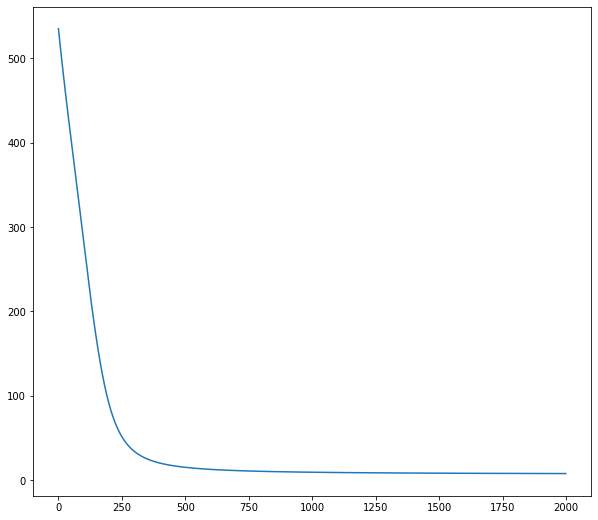

In [48]:
# Show the loss w.r.t step
plt.figure(figsize=(10, 9))
plt.plot(steps, losses)

In [49]:
# To get the embedding of a particular word, e.g. "beauty"
ran_idx = random.randint(0, len(words))
embeds_tensor = model.embeddings.weight[word_to_ix[words[ran_idx]]]
print(f'{words[ran_idx]} => {embeds_tensor}')

thou => tensor([-1.3442,  0.9624,  0.4791,  0.4306, -1.8259, -0.6638, -0.2254, -0.4341,
        -0.5038,  0.6937], grad_fn=<SelectBackward0>)
